# Example 13: Generating spectral distortions

In this example, we will show how to use the upgraded version of DarkHistory to generate distortions to the CMB spectrum from exotic energy injection.

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
from scipy.interpolate import interp1d, interp2d

from darkhistory.config import data_path
import darkhistory.main as main
import darkhistory.physics as phys
from plotting_utils import plot_distortion

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
#######################################
#           CMB Constraints           #
#######################################


# CMB constraints on interaction rates
input_dir = data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

Choose the parameters for your dark matter model. For this example, we will use dark matter decaying to $e^+ e^-$ pairs. We'll take the mass of the dark matter particle to be $m_\chi = 200$ MeV and the lifetime to be at CMB bounds.

Parameters we can tweak that are relevant to the spectral distortion are $n_\mathrm{max}$, the maximum number of hydrogen levels to track, and the number of iterations we run in order to increase the accuracy of the hydrogen transition rates.

In [3]:
pri = 'elec'
DM_process = 'decay'
mDM = 2e8
tau = param_bound(mDM, DM_process, pri)

nmax = 10
iterations = 3

To output the spectral distortion from `main.evolve()`, we must set `distort=True`. If we want to include excitations from dark matter energy injection as a source of spectral distortions, we also set `fexc_switch=True`. Finally, if we want to account for the feedback of the evolving spectral distortion on the atomic transitions rates, we set `reprocess_distortion=True`.

In [4]:
data = main.evolve(
    primary=pri+'_delta', DM_process=DM_process, 
    mDM=mDM, lifetime=tau,
    start_rs = 3000, high_rs = 1.555e3,
    coarsen_factor=16, rtol=1e-6,
    nmax=nmax, iterations=iterations,
    distort=True, fexc_switch = True, 
    reprocess_distortion=True
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/low_energy/atomic.py:412: RuntimeWarning: invalid value encountered in less
  emission_mask[Ennp_mat < 0] *= 0.
../darkhistory/low_energy/atomic.py:415: RuntimeWarning: invalid value encountered in greater
  absorption_mask[Ennp_mat > 0] *= 0.
../darkhistory/low_energy/atomic.py:418: RuntimeWarning: invalid value encountered in less_equal
  non_pos_mask[(Ennp_mat <= 0) | (np.isnan(Ennp_mat))] = 1.


We can plot the total spectral distortion contributed between redshifts $3000 < 1+z < 4$ as seen today. This is output using the `'distortion'` key. We will plot the distortion from the last iteration of `main.evolve()` which is the most accurate. Dashed lines indicate where the spectral distortion has negative values.

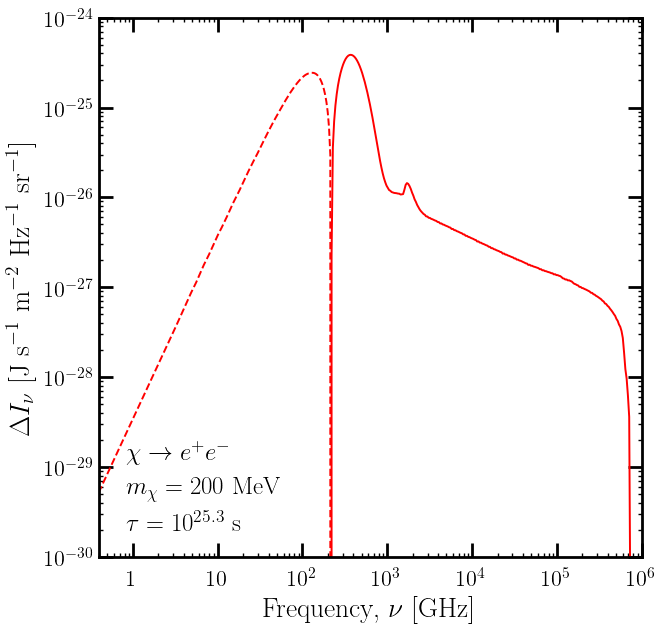

In [5]:
plt.figure(figsize=(7,7))
ax = plt.gca()

plot_distortion(ax, data[-1], color='red')

plt.ylim(1e-30,1e-24)

plt.text(0.05, 0.18, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.11, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.05, r'$\tau = 10^{25.3}$ s', fontsize=18, transform = ax.transAxes)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

plt.show()

Another output is the contribution to the distortion from each redshift step, which is output using the key `'distortions'`. Here, we will plot the contribution from every 20th redshift step.

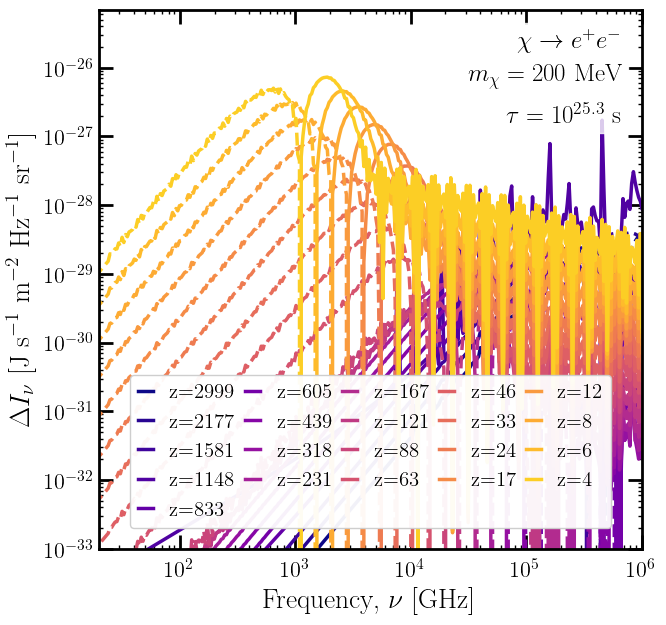

In [6]:
skip = 20
hplanck = phys.hbar * 2*np.pi
color = cm.plasma(np.linspace(0.,.9,len(data[-1]['lowengphot'].rs[::skip])))

plt.figure(figsize=(7,7))
plt.loglog()
ax = plt.gca()

# Plot contribution to distortion from every 20th redshift step
for ii, rs in enumerate(data[-1]['lowengphot'].rs[::skip]):
    plt.plot(data[-1]['distortions'][ii*skip].eng / hplanck / 1e9, 
             data[-1]['distortions'][ii*skip].dNdE * phys.nB * data[-1]['distortions'][ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             label=f'z={rs-1:.0f}', color=color[ii])
    plt.plot(data[-1]['distortions'][ii*skip].eng / hplanck / 1e9, 
             - data[-1]['distortions'][ii*skip].dNdE * phys.nB * data[-1]['distortions'][ii*skip].eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4, 
             linestyle='--', color=color[ii])

plt.axis([20, 1e6, 1e-33, 7e-26])
plt.text(0.77, 0.93, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.68, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.text(0.75, 0.79, r'$\tau = 10^{25.3}$ s', fontsize=18, transform = ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8))
plt.legend(loc='lower center', ncol=5, handlelength=0.7, fontsize=15, 
           columnspacing=0.5, framealpha=0.95)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

plt.show()